In [255]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
import numpy as np
from IPython.display import Image 
from sklearn import cross_validation, ensemble, linear_model
%matplotlib inline

<h2>Predicting relative gene expression from other genomic features</h2>

We will look at a data set that was compiled in order to understand which factors determine relative gene expression in developing mouse cortex and spinal cord. 

<h3>Some background</h3>

The project is about characterizing neural progenitor cell populations in the nervous system (cortex and spinal cord) of E11.5 mouse embryos. Spinal cord and cortex neurons have been subjected to DNaseI-seq, RNA-seq, and ChIP-seq targeting the "master regulator" transcription factor Sox2. 

![title](embryo.png)

The experiments were performed in duplicates or triplicates, and we can analyze each type of data by itself to identify, for instance, differentially expressed genes between progenitors in the two populations ...

![title](DE.png)

... or how many overlapping and unique open chromatin (DNaseI sensitive) regions, or Sox2-bound regions, there are in the respective populations ...

![title](DiffDNase.png)
![title](DiffChIP.png)

Of course these data types can also be related to each other in some different ways. For example, you could look at the relationship between DNaseI profiles and gene expression differences in spinal cord vs. cortex in a scatterplot...

![title](DHS_expr.png)

... or at the relationship between cell type specific DNaseI regions and Sox2 binding regions in a barplot ...

![title](ChIP_DHS.png)

These are useful but still just relating two datasets to each other in a single plot. It is hard to relate several datasets in this way without getting something very complicated. We wanted to try for a different statistical modeling approach where we add various features based on the high-throughput experiments and properties of the genomic sequence, and see if we can predict certain features based on the other ones. We are interested in learning which features contribute the most to the prediction.



<h3>Analysis</h3>
Below, we will try to see how well we can predict the relative gene expression (expressed as log2 fold change between spinal cord and cortex), and which features turn out to be the most informative for that purpose.

<h4>Data preparation</h4>

Let's begin by loading the data into a data frame!

In [256]:
data = pd.read_csv("gene_scores.csv", index_col=0)

Check what the data look like, and how big the data frame is.

In [257]:
print(data.head())
print(data.shape)

                         ctx_dhs  ctx_footprint_no  ctx_sox2no  ctx_sox2score  \
ENSMUSG00000046593   2355.995772          0.816579    0.000000       0.000000   
ENSMUSG00000037972   6248.353861          1.257967    1.579189      37.697030   
ENSMUSG00000037973   2678.187637          0.000000    1.214106      21.523723   
ENSMUSG00000053216  14688.977720         33.567085    5.317266     135.139718   
ENSMUSG00000029510   6050.044463          3.454355    1.560680      15.087589   

                         hox        lhx    log2fc    maxcons  meancons  \
ENSMUSG00000046593  0.241369   0.477784 -0.125293  14.294184  0.699185   
ENSMUSG00000037972  0.447913   0.000000  0.119927  23.306562  0.911032   
ENSMUSG00000037973  0.452227  10.677599 -1.029347  23.738959  3.452806   
ENSMUSG00000053216  0.326184   4.992649 -0.625700  64.571973  7.681191   
ENSMUSG00000029510  0.000000   4.460958  0.730771  32.447952  3.736538   

                          sc_dhs  sc_footprint_no  sc_sox2no  sc_sox

So we have 4540 examples (genes) and 13 values for each - 12 "features" and one "target" (the log2 fold change for each gene in spinal cord vs. cortex). 

<h4>What do the numbers mean? (skip if not interested)</h4>

It doesn't really matter for the rest of the presentation where the values come from, but if you are interested, read on (otherwise skip to "Partition into sub-datasets"). 

The values of the features are weighted sums of various scores that have been calculated for predicted enhancers surrounding a gene. An enhancer close to the gene will contribute a larger fraction of its scores to the feature than one that is further away. Within each enhancer, we have calculated the following things:

- ctx_dhs: The maximal value of a "chromatin openness" score from DNase-seq peak calling performed in cortex (with the DFilter package).
- sc_dhs: -"- for spinal cord
- ctx_footprint_no: Sum of enrichment scores of DNase footprints in cortex (calculated by PyDNAse).
- sc_footprint_no: -"- for spinal cord
- ctx_sox2no: Number of Sox2 ChIP-seq peaks in the enhancer in cortex (defined by SISSRs)
- sc_sox2no: -"- for spinal cord
- ctx_sox2score: Sum of SISSRs scores for the Sox2 ChIP-seq peaks in cortex
- sc_sox2score: -"- for spinal cord 
- hox and lhx: The number of DNA motif matches in the enhancer for a Hox (or Lhx) motif, as defined by HOMER.
- log2fc: The log2 expression fold change (spinal cord/cortex) as defined by DESeq2.
- meancons and maxcons: The mean and maximum, respectively, PhyloP score for the enhancer based on a 46-way multiple alignment of vertebrates.

<h4>Partition into sub-datasets</h4>

Now let's construct the training, validation and test sets. The thing that we want to predict is in the column called log2fc, so let's pull that out into its own variable y. This will be the target for the learning algorithm.

In [258]:
y = data['log2fc']
X = data.drop(['log2fc'],1)

Check that they came out right.

In [259]:
print(y.head())
print(X.head())
print(y.shape)
print(X.shape)

ENSMUSG00000046593   -0.125293
ENSMUSG00000037972    0.119927
ENSMUSG00000037973   -1.029347
ENSMUSG00000053216   -0.625700
ENSMUSG00000029510    0.730771
Name: log2fc, dtype: float64
                         ctx_dhs  ctx_footprint_no  ctx_sox2no  ctx_sox2score  \
ENSMUSG00000046593   2355.995772          0.816579    0.000000       0.000000   
ENSMUSG00000037972   6248.353861          1.257967    1.579189      37.697030   
ENSMUSG00000037973   2678.187637          0.000000    1.214106      21.523723   
ENSMUSG00000053216  14688.977720         33.567085    5.317266     135.139718   
ENSMUSG00000029510   6050.044463          3.454355    1.560680      15.087589   

                         hox        lhx    maxcons  meancons        sc_dhs  \
ENSMUSG00000046593  0.241369   0.477784  14.294184  0.699185   1721.959893   
ENSMUSG00000037972  0.447913   0.000000  23.306562  0.911032   4697.475729   
ENSMUSG00000037973  0.452227  10.677599  23.738959  3.452806   1419.974254   
ENSMUSG0000005321

Divide these into a training set and a test set.

In [260]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

In turn, we can divide this "training set" into a training set and a validation set (which we will use to evaluate each predictive model).

In [261]:
X_tr, X_val, y_tr, y_val = cross_validation.train_test_split(X_train, y_train, test_size=0.3, random_state=53)

How big are these different data sets now?

In [262]:
print("Training:" + str(X_tr.shape))
print("Validation:" + str(X_val.shape))
print("Test:" + str(X_test.shape))

Training:(2224, 12)
Validation:(954, 12)
Test:(1362, 12)


<h4>Correlation heat map</h4>

Are there any obvious correlations between the features?

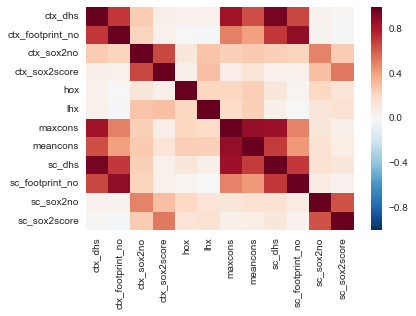

In [263]:
corrs = X.corr()
sns.heatmap(corrs)

Unsurprisingly, the mean and maximum conservation scores are highly correlated, as are the Sox2 counts and scores. In fact this redundancy in features should make us think about dropping a few of them.

<h4>Random forest regression</h4>

For now, though, let's just throw the training set into a random forest regressor (since the target is a continuous value, we use regression rather than classification, which would have been appropriate for a small, discrete set of target values).

Explaining how a random forest works is beyond the scope of this presentation, but for those who care, we choose to build 500 trees with a maximal depth of 5, and restrict the number of features in each tree to a maximum of sqrt(12). We set the oob_score (Out Of Bag score) to True, so we get an estimate of the forest's performance on unseen data. 

In [264]:
np.random.seed(23)
rf = ensemble.RandomForestRegressor(n_estimators=500, oob_score=True, max_features='sqrt', max_depth=5)

In [265]:
# Build a random forest model for the training set
rfit = rf.fit(X_tr, y_tr)

<h4>Check performance and potential overfitting</h4>

In [266]:
print('Training set variance score (R2): %.2f' % rfit.score(X_tr, y_tr))
print('OOB set variance score (R2): %.2f' % rfit.oob_score_)
print('Validation set variance score (R2): %.2f' % rfit.score(X_val, y_val))

Training set variance score (R2): 0.29
OOB set variance score (R2): 0.14
Validation set variance score (R2): 0.16


<h4>Feature importance</h4>

We can also get a measure of how important each feature is for prediction.

In [267]:
def plot_feat_imp(model, feature_names):
    feature_importance = model.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, feature_names[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

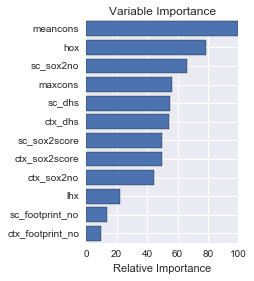

In [268]:
plot_feat_imp(rfit, X_tr.columns)

<h4>Linear regression</h4>

As mentioned above, this dataset contains some highly correlated features, which makes it unlikely to be a good fit for doing linear regression. Let's try it anyway just to see what happens, but in a variant called lasso regression, which can ignore a subset of the features (there are many other variations of linear regression available).

In [269]:
lm = linear_model.Lasso()
lm.fit(X_tr, y_tr)
print('Training set variance score: %.2f' % lm.score(X_tr, y_tr))
print('Validation set variance score: %.2f' % lm.score(X_val, y_val))


Training set variance score: 0.15
Validation set variance score: 0.20


We can look at the estimated coefficients in the linear model.

In [270]:
print(zip(X.columns,lm.coef_))
print(lm.intercept_)

[('ctx_dhs', -0.000407192447909452), ('ctx_footprint_no', -0.0), ('ctx_sox2no', -0.0), ('ctx_sox2score', -0.0022899018920125194), ('hox', 0.0), ('lhx', 0.0), ('maxcons', 0.0), ('meancons', 0.0), ('sc_dhs', 0.00047285734963729002), ('sc_footprint_no', -0.0), ('sc_sox2no', 0.0), ('sc_sox2score', 0.0030000238503714058)]
0.234644326222


<h4>Gradient boosting</h4>

In [271]:
params = {'n_estimators': 500, 'max_depth': 3, 'min_samples_split': 1,
          'learning_rate': 0.05, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_tr, y_tr)


GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.05, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=1,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [272]:
print('Training set variance score: %.2f' % clf.score(X_tr, y_tr))
print('Validation set variance score: %.2f' % clf.score(X_val, y_val))

Training set variance score: 0.67
Validation set variance score: 0.21


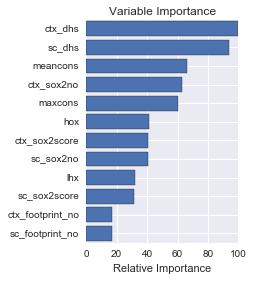

In [273]:
plot_feat_imp(clf, X_tr.columns)

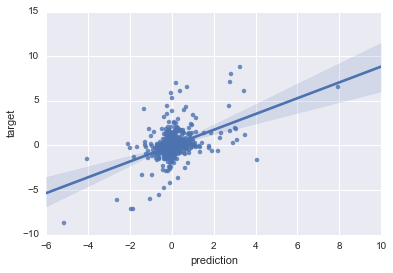

In [274]:
df = pd.DataFrame({'prediction':clf.predict(X_val), 'target':y_val})
df.head()
sns.regplot(df['prediction'], df['target'])

<h4>Feature engineering</h4>

Let's remove some redundant features and create new ones!

In [275]:
X.columns.values

array(['ctx_dhs', 'ctx_footprint_no', 'ctx_sox2no', 'ctx_sox2score', 'hox',
       'lhx', 'maxcons', 'meancons', 'sc_dhs', 'sc_footprint_no',
       'sc_sox2no', 'sc_sox2score'], dtype=object)

In [276]:
X_new = X.drop(['ctx_footprint_no','ctx_sox2no', 'maxcons', 'sc_footprint_no','sc_sox2no'],1)
print(X_new.head())

                         ctx_dhs  ctx_sox2score       hox        lhx  \
ENSMUSG00000046593   2355.995772       0.000000  0.241369   0.477784   
ENSMUSG00000037972   6248.353861      37.697030  0.447913   0.000000   
ENSMUSG00000037973   2678.187637      21.523723  0.452227  10.677599   
ENSMUSG00000053216  14688.977720     135.139718  0.326184   4.992649   
ENSMUSG00000029510   6050.044463      15.087589  0.000000   4.460958   

                    meancons        sc_dhs  sc_sox2score  
ENSMUSG00000046593  0.699185   1721.959893      0.000000  
ENSMUSG00000037972  0.911032   4697.475729     20.850813  
ENSMUSG00000037973  3.452806   1419.974254      0.000000  
ENSMUSG00000053216  7.681191  12665.480738     33.012300  
ENSMUSG00000029510  3.736538   5181.369592      0.000000  


Now that we have removed some redundant features, we want to create a new feature which is the (log2) ratio between sc_dhs and ctx_dhs: two features that we have seen are informative. However, in order to avoid division by zero, we need to add some small value to each value in sc_dhs and ctx_dhs. In this case, we just add the smallest non-zero value for each.

In [277]:
min_nonzero_ctx_dhs = min(X_new['ctx_dhs'][X_new['ctx_dhs']>0])
min_nonzero_sc_dhs = min(X_new['sc_dhs'][X_new['sc_dhs']>0])
dhs_fc = (X_new['sc_dhs']+min_nonzero_sc_dhs)/(X_new['ctx_dhs']+min_nonzero_ctx_dhs)

# Create a new feature with the same idea, but for the Sox2 scores instead: log2(sc_sox2score/ctx_sox2score) with some small values added
min_nonzero_ctx_sox2score = min(X_new['ctx_sox2score'][X_new['ctx_sox2score']>0])
min_nonzero_sc_sox2score = min(X_new['sc_sox2score'][X_new['sc_sox2score']>0])
sox2score_fc = (X_new['sc_sox2score']+min_nonzero_sc_sox2score)/(X_new['ctx_sox2score']+min_nonzero_ctx_sox2score)

In [278]:
X_new['dhs_log2fc'] = map(np.log2, dhs_fc)
X_new['sox2_log2fc'] = map(np.log2, sox2score_fc)
#X_new['ctx_dhs'] = np.log10(X_new['ctx_dhs'])
#X_new['sc_dhs'] = np.log10(X_new['sc_dhs'])

In [279]:
X_new.head()

,ctx_dhs,ctx_sox2score,hox,lhx,meancons,sc_dhs,sc_sox2score,dhs_log2fc,sox2_log2fc
ENSMUSG00000046593,2355.995772,0.000000,0.241369,0.477784,0.699185,1721.959893,0.000000,-0.444487,0.528619
ENSMUSG00000037972,6248.353861,37.697030,0.447913,0.000000,0.911032,4697.475729,20.850813,-0.408900,-0.835422
ENSMUSG00000037973,2678.187637,21.523723,0.452227,10.677599,3.452806,1419.974254,0.000000,-0.899794,-5.599843
ENSMUSG00000053216,14688.977720,135.139718,0.326184,4.992649,7.681191,12665.480738,33.012300,-0.213216,-2.017161
ENSMUSG00000029510,6050.044463,15.087589,0.000000,4.460958,3.736538,5181.369592,0.000000,-0.222061,-5.096048


<h4>Re-divide dataset</h4>

In [280]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_new, y, test_size=0.3, random_state=42)
X_tr, X_val, y_tr, y_val = cross_validation.train_test_split(X_train, y_train, test_size=0.3, random_state=53)

<h4>Random forest, lasso and gradient boosting on the new dataset</h4>

In [281]:
rf = ensemble.RandomForestRegressor(n_estimators=500, oob_score=True, max_features='sqrt', max_depth=5)
rf.fit(X_tr, y_tr)
lm = linear_model.Lasso()
lm.fit(X_tr, y_tr)
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_tr, y_tr)

print('Random forest training set variance score: %.2f' % rf.score(X_tr, y_tr))
print('Random forest validation set variance score: %.2f' % rf.score(X_val, y_val))
print('Lasso training set variance score: %.2f' % lm.score(X_tr, y_tr))
print('Lasso validation set variance score: %.2f' % lm.score(X_val, y_val))
print('Gradient boosting training set variance score: %.2f' % clf.score(X_tr, y_tr))
print('Gradient boosting validation set variance score: %.2f' % clf.score(X_val, y_val))

Random forest training set variance score: 0.33
Random forest validation set variance score: 0.21
Lasso training set variance score: 0.15
Lasso validation set variance score: 0.20
Gradient boosting training set variance score: 0.67
Gradient boosting validation set variance score: 0.22


Let's look at the most important parameters in the "winning" model.

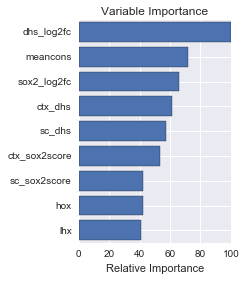

In [282]:
plot_feat_imp(clf, X_tr.columns)

Now for the final test: Will the model work on the held-out test set too?

In [283]:
print('Test set variance score: %.2f' % rf.score(X_test, y_test))

Test set variance score: 0.22
